# Knot sizes

Comparison between different ways of measuring this. 

In [1]:
import numpy as np
import typer
from astropy.table import Table, QTable, join
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd

In [2]:
ORIGIN = SkyCoord.from_name("wr124", cache=True)

In [3]:
from pathlib import Path

In [4]:
datapath = Path.cwd().parent / "data" / "reproject"

## Separations between the knot peaks in different tracers

In [7]:
AA_D_table = QTable.read(datapath / "combo-AA-neutral-combo-D-neutral-knot-seps.ecsv")
DD_D_table = QTable.read(datapath / "combo-DD-neutral-combo-D-neutral-knot-seps.ecsv")
EE_D_table = QTable.read(datapath / "combo-E-ionized-combo-D-neutral-knot-seps.ecsv")

In [10]:
AA_D_table.rename_column("dR", "dR(AA-D)")
DD_D_table.rename_column("dR", "dR(DD-D)")
EE_D_table.rename_column("dR", "dR(EE-D)")

In [13]:
dr_table = join(join(AA_D_table, DD_D_table[["label", "dR(DD-D)"]]), EE_D_table[["label", "dR(EE-D)"]])

In [14]:
dr_table.show_in_notebook()

idx,label,PA,R,dR(AA-D),dR(DD-D),dR(EE-D)
,,deg,arcsec,arcsec,arcsec,arcsec
0,PA001-R163,0.8698648579361684,16.245966250149422,0.0690083308111121,0.06254250474664776,0.07287938792275919
1,PA002-R153,2.1181482259414346,15.299324076033525,-0.021183787379078223,0.07787601595905871,0.017620378940561704
2,PA004-R164,4.409480231911589,16.306989015603897,0.18149840812691603,0.15023837458638145,0.16376725240924672
3,PA005-R101,5.0073121388263475,10.120692209224904,0.15031479769965045,0.05985644549026548,0.21284702516186846
4,PA005-R178,5.2731820214216745,17.682354586576412,0.03819659943299185,0.09907020999545095,0.06255421630441821
5,PA006-R185,5.522816344565724,18.554518880449542,0.07108094216187917,0.10124094077644877,0.11014649366061398
6,PA017-R038,16.829907671084754,3.3493585229578255,0.4104103238133642,0.08108826309901532,-0.01647903830722273
7,PA028-R054,28.041795442239398,5.387141879101176,0.03213829450265625,0.0403461534949824,0.06683943743005663
8,PA031-R033,30.919260644413303,3.4116726578246155,0.012307428904131251,0.17864388504792592,0.21894522472842715


In [121]:
df = dr_table.to_pandas().set_index("label")

In [122]:
df.describe()

,PA,R,dR(AA-D),dR(DD-D),dR(EE-D)
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,168.106306,16.993089,0.085560,0.073168,0.080267
std,98.237645,7.126710,0.074087,0.098691,0.094062
min,0.869865,2.931549,-0.160717,-0.479362,-0.249390
25%,84.269931,11.561891,0.046616,0.044192,0.034202
50%,179.449465,16.369898,0.080540,0.072164,0.082803
75%,220.170986,21.789643,0.127263,0.115126,0.126160
max,359.624498,35.220427,0.410410,0.373487,0.375196


Remove outliers

In [123]:
drmin, drmax = -0.1, 0.3
for col in df.columns:
    if col.startswith("dR"):
        m = (df[col] < drmin) | (df[col] > drmax)
        df.loc[m, col] = np.nan

In [124]:
df.describe()

,PA,R,dR(AA-D),dR(DD-D),dR(EE-D)
count,168.000000,168.000000,163.000000,157.000000,157.000000
mean,168.106306,16.993089,0.088925,0.081707,0.081808
std,98.237645,7.126710,0.061710,0.065851,0.070412
min,0.869865,2.931549,-0.059916,-0.082465,-0.090121
25%,84.269931,11.561891,0.048029,0.047028,0.040196
50%,179.449465,16.369898,0.080967,0.075092,0.083303
75%,220.170986,21.789643,0.127441,0.114803,0.122093
max,359.624498,35.220427,0.298239,0.261382,0.273267


In [125]:
df.corr()

,PA,R,dR(AA-D),dR(DD-D),dR(EE-D)
PA,1.000000,0.140353,0.141097,0.198037,0.222473
R,0.140353,1.000000,0.191310,0.086283,0.013085
dR(AA-D),0.141097,0.191310,1.000000,0.608580,0.401885
dR(DD-D),0.198037,0.086283,0.608580,1.000000,0.356736
dR(EE-D),0.222473,0.013085,0.401885,0.356736,1.000000


Correlations between displacements are OK: 0.4 to 0.6. Best between AA-D and DD-D

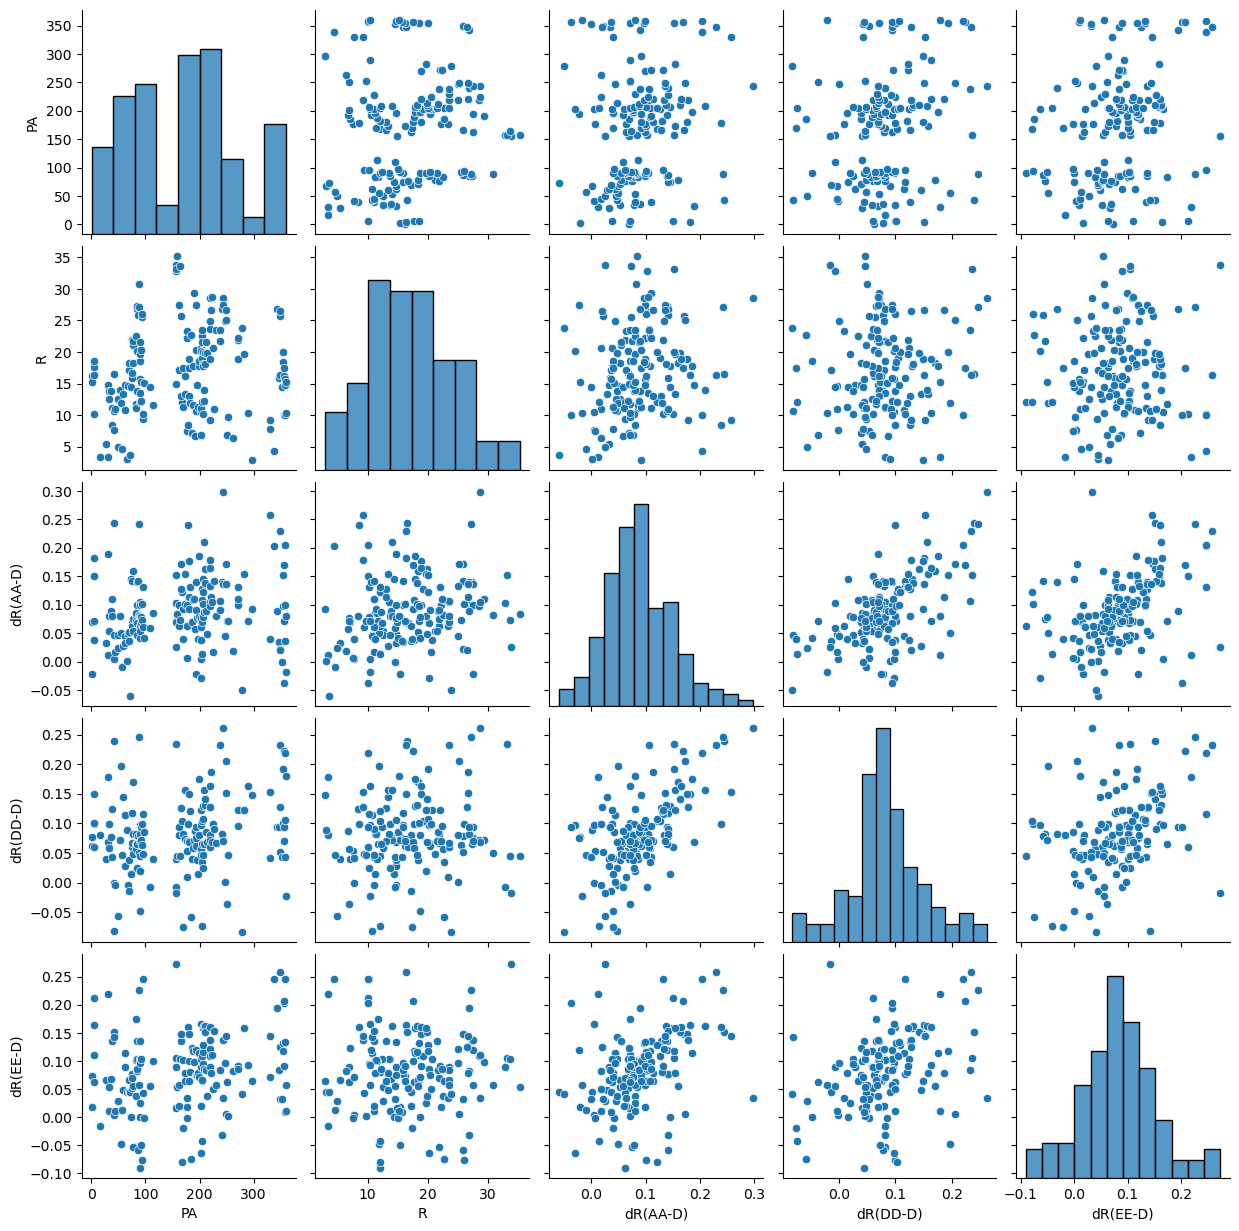

In [126]:
sns.pairplot(df)

## Sizes from fitting ellipses

In [127]:
wanted = ["label", "Ellipse Sigma X", "Ellipse Sigma Y"]
etables = {
    "AA": QTable.read(datapath / "combo-AA-neutral-knot-ellipses.ecsv")[wanted],
    "DD": QTable.read(datapath / "combo-DD-neutral-knot-ellipses.ecsv")[wanted],
    "D": QTable.read(datapath / "combo-D-neutral-knot-ellipses.ecsv")[wanted],
    "E": QTable.read(datapath / "combo-E-ionized-knot-ellipses.ecsv")[wanted],
    "H": QTable.read(datapath / "wr124-hst-2008-f656n-radec-knot-ellipses.ecsv")[wanted],
}


In [128]:
for key, tab in etables.items():
    tab.rename_columns(wanted[1:3], [f"sigx({key})", f"sigy({key})"])

In [129]:
sig_table = None
for key, tab in etables.items():
    if sig_table is None:
        sig_table = tab
    else:
        sig_table = join(sig_table, tab)

In [130]:
sig_table.show_in_notebook()

idx,label,sigx(AA),sigy(AA),sigx(DD),sigy(DD),sigx(D),sigy(D),sigx(E),sigy(E),sigx(H),sigy(H)
,,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec
0,PA001-R163,0.06499598146480663,0.05585638524947341,0.0602486660630757,0.07010162929957983,0.11824005044015481,0.2311868164073051,0.5483603828872614,0.7824120209472158,0.5435680531681344,0.7430364497397466
1,PA002-R153,0.18965599175811962,0.25621269953216896,0.09299999999999989,0.09299999999999989,0.08228979378889613,0.07556883380557101,0.8169402513822707,0.3340960808937337,1.0375169658032346,0.34546529823925703
2,PA004-R164,0.15084615354206315,0.1727195936736008,0.03099999999999996,0.03099999999999996,0.18632526647785638,0.17463056185314105,0.33211511941638855,1.0173004014464806,0.15138690380971223,0.4157656315233866
3,PA005-R101,0.16342484978731905,0.17799637870312265,0.20143902793854312,0.1944113290011641,0.28419901407476245,0.09784108763350192,0.14871560594860106,0.12087789426647948,0.18820788578403372,0.12459255159986715
4,PA005-R178,0.043645890203465015,0.046374401744797025,0.03099999999999996,0.03099999999999996,0.07756226607077318,0.08103215833580557,0.4427758323752854,0.511180509747699,0.40474528165185975,0.6565799178374926
5,PA006-R185,0.0630519586346304,0.06560756640655892,0.06155403512430655,0.06727216895068616,0.11813709839942688,0.22077772794841993,0.17875555686627637,0.13205235829933626,0.2514321755550521,0.22058715084603397
6,PA017-R038,2.4110513571552694,7.571814883513041,0.7239014083790096,0.40754280127097847,0.12890287951487245,0.09674254401017067,0.32565207707387717,0.30326069319350485,0.38121583845703216,0.2934085345393852
7,PA028-R054,0.19199115286444188,0.20196509131970972,0.42742549463622836,0.48040824330639087,0.107094016434982,0.12067666457324272,0.03099999999999996,0.03099999999999996,0.06640739519876751,0.07008742694028976
8,PA031-R033,2.7327004618997823,0.2712805616326687,0.29720580583075945,1.234891557339338,0.2318598156355636,0.13899863145449828,0.1955134587715322,0.12529595813881195,0.14797774610891648,0.10064890489059924


In [131]:
sdf = sig_table.to_pandas().set_index("label")

In [132]:
sdf.describe()

,sigx(AA),sigy(AA),sigx(DD),sigy(DD),sigx(D),sigy(D),sigx(E),sigy(E),sigx(H),sigy(H)
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,0.189297,0.211146,9.501654,2.057401,0.167395,0.186697,0.410490,0.388603,0.351749,0.329259
std,0.393474,0.737747,107.487746,16.534651,0.120110,0.267581,0.546559,0.486643,0.413912,0.351359
min,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0.066407,0.070087
25%,0.062137,0.069250,0.080898,0.085217,0.109641,0.113010,0.171803,0.172388,0.166643,0.172998
50%,0.097967,0.095465,0.125723,0.125400,0.133674,0.136477,0.270768,0.267675,0.235817,0.244416
75%,0.152759,0.135252,0.235551,0.217215,0.186639,0.172288,0.447755,0.425189,0.391546,0.350796
max,2.732700,7.571815,1384.989686,178.880050,1.145234,3.100577,5.225164,4.911740,3.380791,3.532263


In [133]:
sdf.columns

Index(['sigx(AA)', 'sigy(AA)', 'sigx(DD)', 'sigy(DD)', 'sigx(D)', 'sigy(D)',
       'sigx(E)', 'sigy(E)', 'sigx(H)', 'sigy(H)'],
      dtype='object')

Discard extreme outliers by imposing max of 0.3 arcsec for the neutral ones and 0.6 for the ionized ones because they are bigger

In [134]:
sigmin, sigmax = 0.0, 0.3
esigmax = 0.6
for col in sdf.columns:
    if col.startswith("sig"):
        if "(E)" in col or "(H)" in col:
            smax = esigmax
        else:
            smax = sigmax
        m = (sdf[col] < sigmin) | (sdf[col] > smax)
        sdf.loc[m, col] = np.nan

In [135]:
sdf.describe()

,sigx(AA),sigy(AA),sigx(DD),sigy(DD),sigx(D),sigy(D),sigx(E),sigy(E),sigx(H),sigy(H)
count,153.000000,156.000000,143.000000,141.000000,158.000000,156.000000,143.000000,146.000000,152.000000,152.000000
mean,0.103920,0.102275,0.126566,0.123100,0.144934,0.141518,0.263026,0.259466,0.252236,0.245802
std,0.057175,0.053147,0.073222,0.064939,0.052488,0.044377,0.135906,0.138090,0.117815,0.109277
min,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0.031000,0.066407,0.070087
25%,0.059738,0.067286,0.073163,0.070514,0.108208,0.111462,0.156823,0.155681,0.161315,0.169020
50%,0.094732,0.091467,0.106417,0.109520,0.128838,0.132771,0.248484,0.244081,0.212934,0.222378
75%,0.139571,0.123352,0.176090,0.160502,0.166868,0.161634,0.328884,0.353069,0.345063,0.297076
max,0.275991,0.291674,0.299825,0.295724,0.295518,0.276623,0.594713,0.593076,0.555056,0.595289


In [136]:
sdf.corr()

,sigx(AA),sigy(AA),sigx(DD),sigy(DD),sigx(D),sigy(D),sigx(E),sigy(E),sigx(H),sigy(H)
sigx(AA),1.000000,0.692567,0.377318,0.264691,0.055568,0.111015,-0.124248,0.015918,0.007251,0.060376
sigy(AA),0.692567,1.000000,0.341597,0.443135,0.056452,0.126335,-0.108651,-0.058539,0.019744,0.089280
sigx(DD),0.377318,0.341597,1.000000,0.781472,0.108856,0.087152,-0.120159,-0.244930,-0.086647,-0.149213
sigy(DD),0.264691,0.443135,0.781472,1.000000,-0.056314,0.087221,-0.078976,-0.168177,-0.087203,-0.176038
sigx(D),0.055568,0.056452,0.108856,-0.056314,1.000000,0.188390,0.070780,0.001917,0.065681,0.094949
sigy(D),0.111015,0.126335,0.087152,0.087221,0.188390,1.000000,-0.014733,-0.037058,-0.037392,0.069060
sigx(E),-0.124248,-0.108651,-0.120159,-0.078976,0.070780,-0.014733,1.000000,0.678676,0.673564,0.330714
sigy(E),0.015918,-0.058539,-0.244930,-0.168177,0.001917,-0.037058,0.678676,1.000000,0.441997,0.518787
sigx(H),0.007251,0.019744,-0.086647,-0.087203,0.065681,-0.037392,0.673564,0.441997,1.000000,0.690043
sigy(H),0.060376,0.089280,-0.149213,-0.176038,0.094949,0.069060,0.330714,0.518787,0.690043,1.000000


We have a good correlation between x and y for the same image but we are really interested in correlations between images. So divide into the x and y sigmas to look at separately. 

In [137]:
xcols = [_ for _ in sdf.columns if _.startswith("sigx")]
ycols = [_ for _ in sdf.columns if _.startswith("sigy")]

In [138]:
sdf[xcols].corr()

,sigx(AA),sigx(DD),sigx(D),sigx(E),sigx(H)
sigx(AA),1.000000,0.377318,0.055568,-0.124248,0.007251
sigx(DD),0.377318,1.000000,0.108856,-0.120159,-0.086647
sigx(D),0.055568,0.108856,1.000000,0.070780,0.065681
sigx(E),-0.124248,-0.120159,0.070780,1.000000,0.673564
sigx(H),0.007251,-0.086647,0.065681,0.673564,1.000000


In [139]:
sdf[ycols].corr()

,sigy(AA),sigy(DD),sigy(D),sigy(E),sigy(H)
sigy(AA),1.000000,0.443135,0.126335,-0.058539,0.089280
sigy(DD),0.443135,1.000000,0.087221,-0.168177,-0.176038
sigy(D),0.126335,0.087221,1.000000,-0.037058,0.069060
sigy(E),-0.058539,-0.168177,-0.037058,1.000000,0.518787
sigy(H),0.089280,-0.176038,0.069060,0.518787,1.000000


For sigx, the best correlation is between E and H (r=0.67), which is good since they are both supposed to trace the ionized gas. 

There is moderate correlation between AA and DD (r=0.38), which both should trace the near PDR. 

The correlation with D is very weak (r~=0.1), probably because D is lower resolution, so sig never drops below 0.1 arcsec. 

Results for sigy are very similar

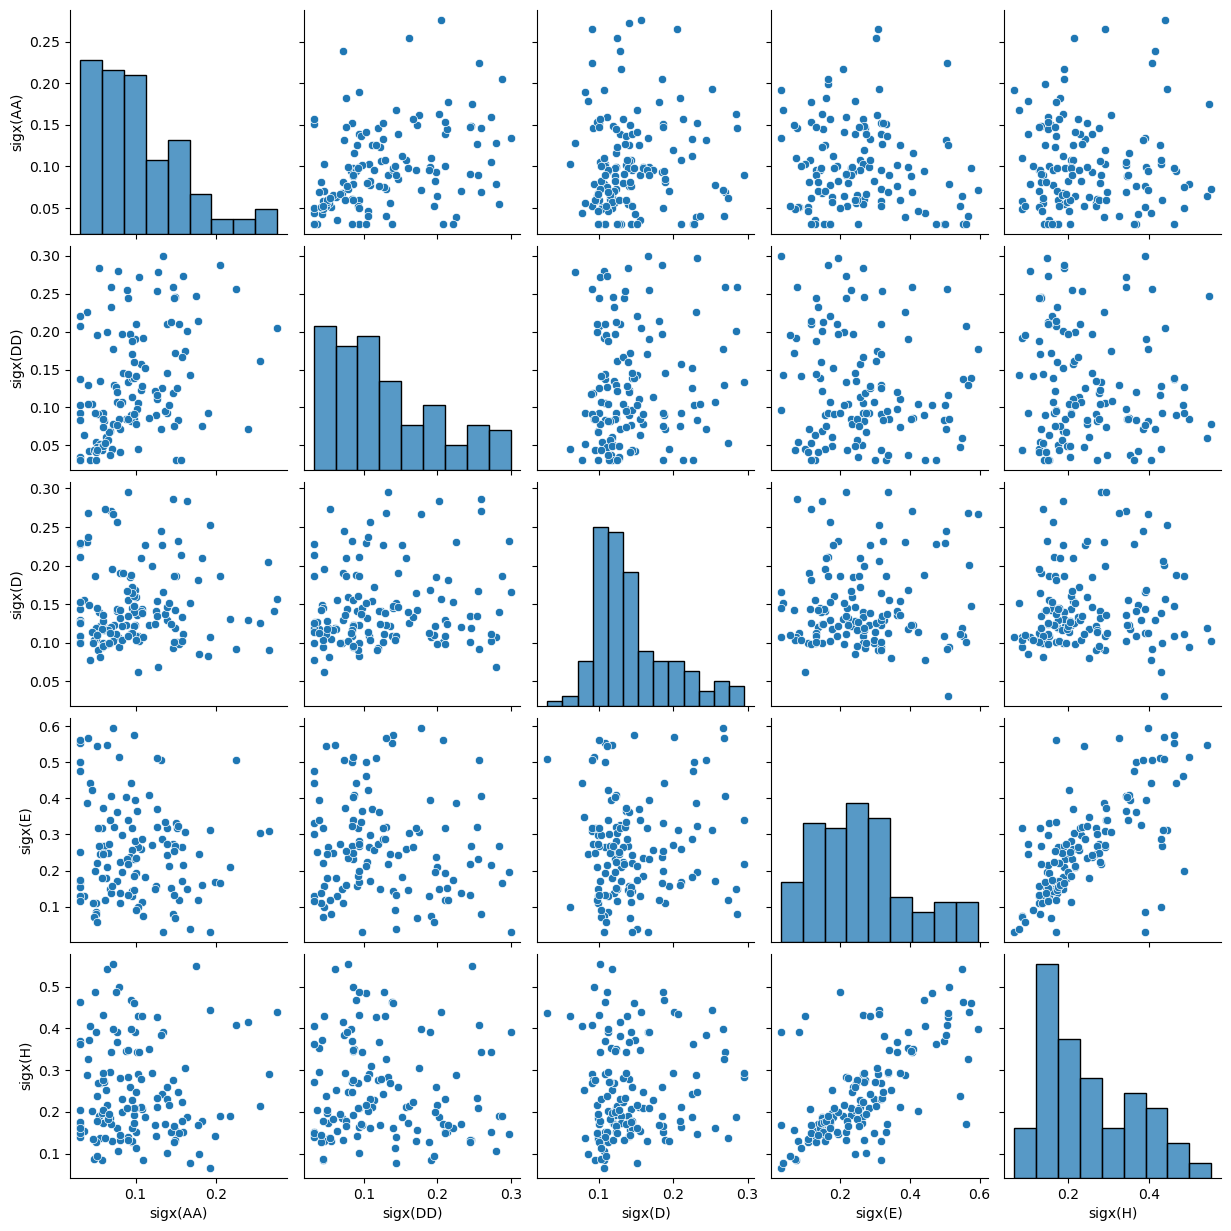

In [140]:
sns.pairplot(sdf[xcols])

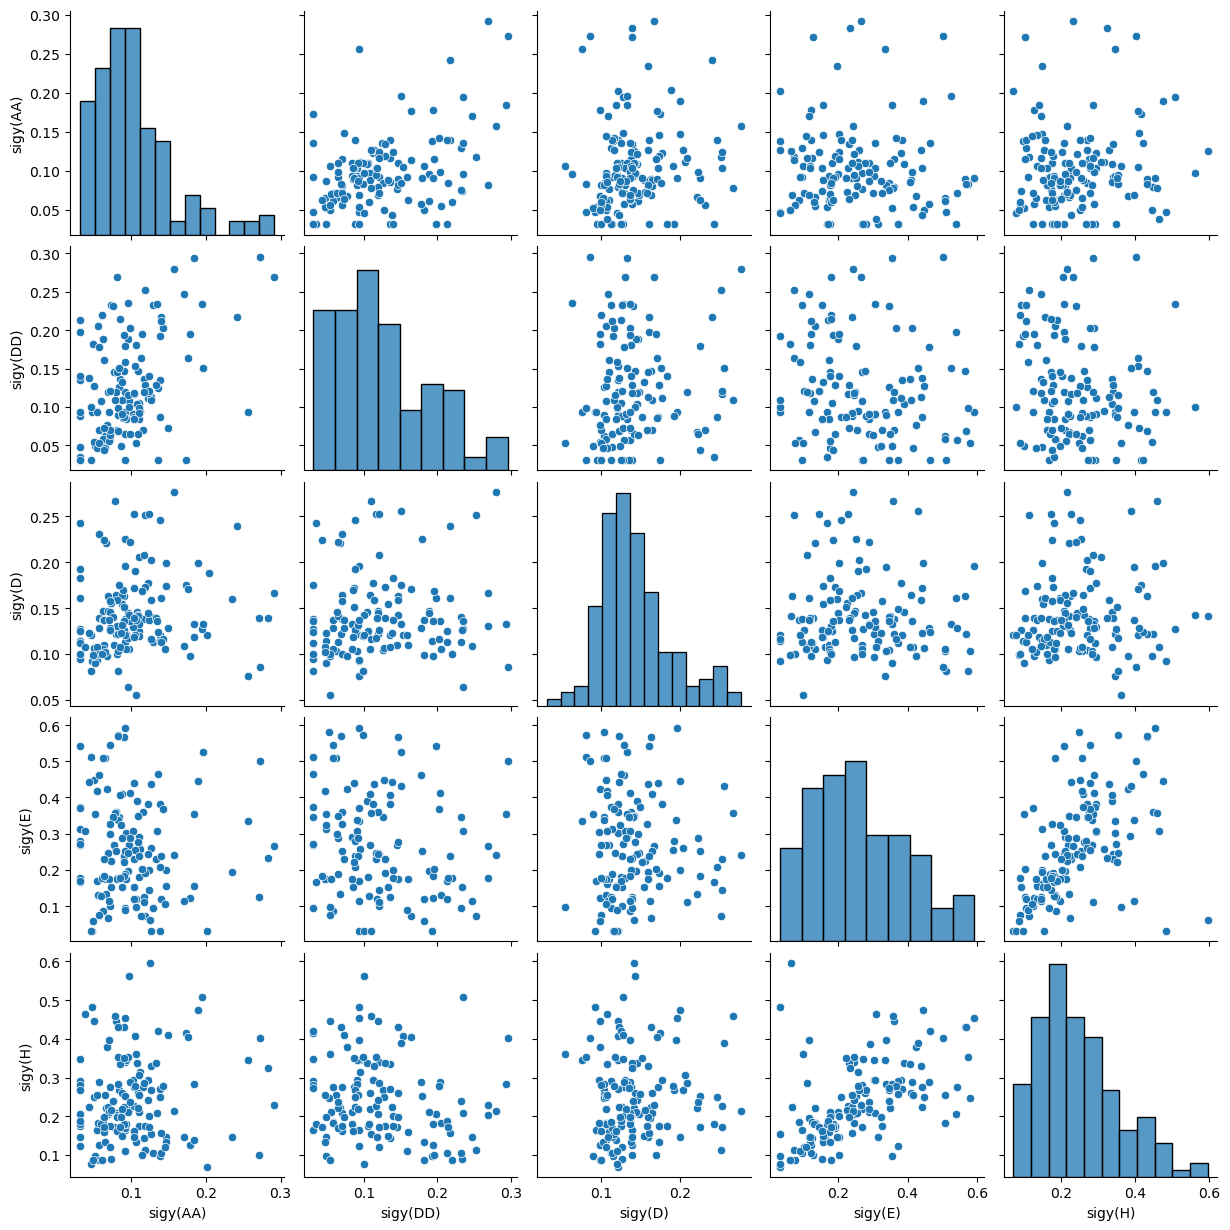

In [141]:
sns.pairplot(sdf[ycols])

## Combine the sigmas with the displacements

In [160]:
dff = df.join(sdf[xcols])

In [161]:
dff

,PA,R,dR(AA-D),dR(DD-D),dR(EE-D),sigx(AA),sigx(DD),sigx(D),sigx(E),sigx(H)
label,,,,,,,,,,
PA001-R163,0.869865,16.245966,0.069008,0.062543,0.072879,0.064996,0.060249,0.118240,0.548360,0.543568
PA002-R153,2.118148,15.299324,-0.021184,0.077876,0.017620,0.189656,0.093000,0.082290,NaN,NaN
PA004-R164,4.409480,16.306989,0.181498,0.150238,0.163767,0.150846,0.031000,0.186325,0.332115,0.151387
PA005-R101,5.007312,10.120692,0.150315,0.059856,0.212847,0.163425,0.201439,0.284199,0.148716,0.188208
PA005-R178,5.273182,17.682355,0.038197,0.099070,0.062554,0.043646,0.031000,0.077562,0.442776,0.404745
...,...,...,...,...,...,...,...,...,...,...
PA357-R101,357.463180,10.003384,0.204484,0.218715,0.246611,0.226531,NaN,NaN,NaN,NaN
PA357-R148,357.133878,14.717319,0.099425,0.106577,0.133486,0.059955,0.074331,0.136212,0.372258,0.292871
PA357-R158,356.791878,15.718994,0.035790,0.043918,0.008706,0.147676,0.075448,0.187018,0.253646,0.166965


Eliminate negative dR

In [162]:
for col in dff.columns:
    if col.startswith("dR"):
        m = dff[col] <= 0.0
        dff.loc[m, col] = np.nan

In [163]:
dff.corr()

,PA,R,dR(AA-D),dR(DD-D),dR(EE-D),sigx(AA),sigx(DD),sigx(D),sigx(E),sigx(H)
PA,1.000000,0.140353,0.217603,0.211779,0.165332,0.036593,0.003411,0.054525,-0.091589,-0.172722
R,0.140353,1.000000,0.175869,0.078587,0.020306,-0.297810,-0.263704,-0.012883,0.125402,0.100190
dR(AA-D),0.217603,0.175869,1.000000,0.583326,0.462531,-0.011335,-0.067508,0.011790,-0.071275,-0.110820
dR(DD-D),0.211779,0.078587,0.583326,1.000000,0.398124,0.119774,0.091240,0.155118,-0.153383,0.020317
dR(EE-D),0.165332,0.020306,0.462531,0.398124,1.000000,0.183262,0.110798,0.118572,0.026624,-0.037470
sigx(AA),0.036593,-0.297810,-0.011335,0.119774,0.183262,1.000000,0.377318,0.055568,-0.124248,0.007251
sigx(DD),0.003411,-0.263704,-0.067508,0.091240,0.110798,0.377318,1.000000,0.108856,-0.120159,-0.086647
sigx(D),0.054525,-0.012883,0.011790,0.155118,0.118572,0.055568,0.108856,1.000000,0.070780,0.065681
sigx(E),-0.091589,0.125402,-0.071275,-0.153383,0.026624,-0.124248,-0.120159,0.070780,1.000000,0.673564
sigx(H),-0.172722,0.100190,-0.110820,0.020317,-0.037470,0.007251,-0.086647,0.065681,0.673564,1.000000


In [164]:
drcols = [_ for _ in dff.columns if _.startswith("dR")]

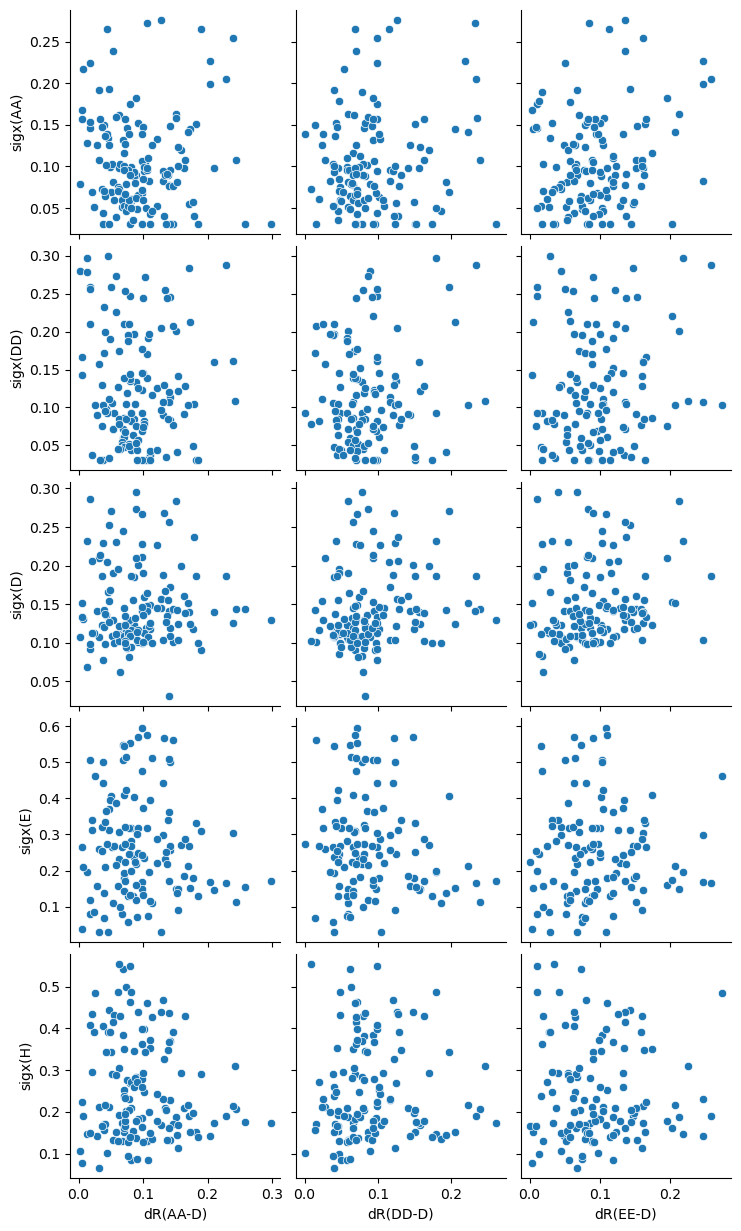

In [165]:
sns.pairplot(dff, x_vars=drcols, y_vars=xcols)

In [171]:
cdf = dff[drcols + xcols].corr()
sol = (cdf.where(np.triu(np.ones(cdf.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head(15)

sigx(E)   sigx(H)     0.926244
dR(AA-D)  dR(DD-D)    0.583326
          dR(EE-D)    0.462531
dR(DD-D)  dR(EE-D)    0.398124
sigx(AA)  sigx(DD)    0.377318
dR(EE-D)  sigx(AA)    0.183262
dR(DD-D)  sigx(D)     0.155118
          sigx(AA)    0.119774
dR(EE-D)  sigx(D)     0.118572
          sigx(DD)    0.110798
sigx(DD)  sigx(D)     0.108856
dR(DD-D)  sigx(DD)    0.091240
sigx(AA)  sigx(H)     0.070596
          sigx(D)     0.055568
dR(EE-D)  sigx(E)     0.045456
dtype: float64

So the numbers say that the best dR-sigx correlation 

```
 	 	 	dR(AA-D)	dR(DD-D)	dR(EE-D)
 	 	 	-------- 	-------- 	--------
sigx(AA)	-0.011335	0.119774	0.183262
sigx(DD)	-0.067508	0.091240	0.110798
sigx(D)		0.011790	0.155118	0.118572
sigx(E) 	-0.071275	-0.153383	0.026624
sigx(H) 	-0.110820	0.020317	-0.037470	

```
is between dR(EE-D) and sigx(AA) with r=0.18 (not great!)

But all the dR(DD-D) and dR(EE-D) correlations with sigx(AA), sigx(DD), sigx(D) are similar (r=0.1 to 0.2)

Apart from that, there are non-existent or negative correlations for dR(AA-D) with all sigx, and for all dR with sigx(E) and (H).

*We clearly need better measurements of the widths*